# Test Script - Neural Net Regressor

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from joblib import dump,load
from utils import StepWiseDecay as SWD
import utils
import pickle
import random
import time

from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct, ExpSineSquared, Matern, RBF
from sklearn.decomposition import TruncatedSVD

from torch import nn
import torch
from nnr_custom import Torch_Model_BasicRegressor as bNNR
import skorch
from skorch import NeuralNetRegressor as SkorchNNR, NeuralNetClassifier as SkorchNNC
from skorch.callbacks import EarlyStopping
from modAL.models import BayesianOptimizer, ActiveLearner
from modAL.acquisition import max_EI, max_PI, max_UCB, optimizer_EI,optimizer_PI, optimizer_UCB

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
# parameters
fingerprint = 'morgan'
model = 'NNR'
file_name = "complete_file_morgan.feather"
config_file_name = 'NNR.json'
use_unified_file = True
assay_limit = 300

## Helper Functions

In [3]:
random.seed(42)
file_path = '/data_temp/default_{}/'.format(fingerprint)

try:
    if use_unified_file == True:
        try:
            df = pd.read_feather("../data" + file_path + file_name)
        except:
            df = pd.read_parquet("../data" + file_path + file_name)
        df_nan = pd.read_parquet("../data" + file_path + "assay_id/assay_id_null_file.parquet")
        df_assays = pd.read_parquet("../data" + file_path + "assay_id/assay_id_file.parquet")

    elif use_unified_file == False:
        df_fingerprint = pd.read_parquet("../" + file_path + "/fingerprint/{}_fingerprint_file.parquet".format(fingerprint))
        df = pd.read_parquet("../" + file_path + "/preprocessed/preprocessed_file.parquet")
        df_nan = pd.read_parquet("../" + file_path + "/assay_id/assay_id_null_file.parquet")
        df_assays = pd.read_parquet("../" + file_path + "/assay_id/assay_id_file.parquet")
    else:
        print("Incorrect value for 'use_unified_file' parameter passed. Please recheck.")
        pass
except:
    print("Data File not found")

In [4]:
df_nan.loc[df_nan['squared_pearson_trn'].isnull()]

,assay_id,squared_pearson_trn,squared_pearson_tst,assay_length_trn,assay_length_tst,assay_length_total
1,303216,NaN,NaN,45,15,60
2,303260,NaN,NaN,45,15,60
4,737235,NaN,NaN,45,15,60


In [5]:
# df = df.drop(nan_assays)
for i in df_nan.loc[df_nan['squared_pearson_trn'].isnull()]['assay_id']:
    df = df.drop(labels = df.loc[df['assay_id']==i].index)
df.loc[df['assay_id']==303216].head()
print('x-----x-----x-----x')
df.loc[df['assay_id']==303260].head()
print('x-----x-----x-----x')
df.loc[df['assay_id']==737235].head()
print('x-----x-----x-----x')

x-----x-----x-----x
x-----x-----x-----x
x-----x-----x-----x


In [6]:
# Loading JSON config file
try:
    with open('../config/' + config_file_name) as f:
        params_config = json.load(f)
        print('JSON config file for {} successfully loaded'.format(model))
except FileNotFoundError:
    print('Config file for model {} is missing.Resorting to default params'.format(model))
    with open('../config/{}_default.json'.format(model)) as f:
        params_config = json.load(f)
try:
    with open('../config/decay_values.json') as f:
        decay_list = json.load(f)
        decay_list = decay_list["decay values"]
except:
    decay_list = [1.0,0.75,0.5,0.25,0.125,0.1,0.05]
    print('Config file for decay values is missing. Resorting to default values: {}'.format(decay_list))

if os.path.isdir('../models/{0}_{1}/'.format(model,fingerprint)) == False:
    os.mkdir('../models/{0}_{1}/'.format(model,fingerprint))

if os.path.isdir('../data/data_results/{0}_{1}/'.format(model,fingerprint)) == False:
    os.mkdir('../data/data_results/{0}_{1}/'.format(model,fingerprint))

if os.path.isdir('../data/data_results/{0}_{1}/plots'.format(model,fingerprint)) == False:
    os.mkdir('../data/data_results/{0}_{1}/plots'.format(model,fingerprint))

# Creating List of Classifiers
clfs = []
acquisition_list = []
clf_list = []
count = 0
clf_list_names = []

for neural_net in params_config["model"]:
    if neural_net == "BasicNNR()":
        clf_type = bNNR
    else:
        clf_type = bNNR
    clf = {
        "type" : clf_type,
        "name" : neural_net
    }
    clfs.append(clf)

for function in params_config["acquisition"]:
    if function=="max_EI":
        acquisition_type = max_EI
    elif function=="max_PI":
        acquisition_type = max_PI
    elif function=="max_UCB":
        acquisition_type = max_UCB
    elif function=="random":
        acquisition_type = utils.random_sampling
    elif function=="equivalent":
        acquisition_type = utils.equivalent_sampling
    elif function=="margin_entropy":
        acquisition_type = utils.margin_entropy_sampling
    elif function=="uncertainty_margin":
        acquisition_type = utils.uncertainty_margin_sampling
    elif function=="product_sampling":
        acquisition_type = utils.product_sampling
    else:
        acquisition_type = max_EI
    acquisition = {
        "type" : acquisition_type,
        "name": function
    }
    acquisition_list.append(acquisition)
if params_config["optimizer"] == "Adam":
    default_optimizer = torch.optim.Adam
    
for model_selected in clfs:
    for ac_func in acquisition_list:
        for lr in params_config["learning_rate"]:
            clf = {
                "model" :model_selected["type"],
                "model_name" : model_selected["name"],
                "acquisition_function" :ac_func["type"],
                "acquisition_function_name" : ac_func["name"],
                "learning_rate" : lr,
                "optimizer" : default_optimizer
            }
            clf_list.append(clf)
            clf_list_names.append("model_{}_{}_{}".format(clf["model_name"], clf["learning_rate"], clf["acquisition_function_name"]))

clf_list_names = ['assay_id','subset_size_trn','total_length'] + clf_list_names

num_iterations=params_config["iterations"]

JSON config file for NNR successfully loaded


In [7]:
clf_list_names

['assay_id',
 'subset_size_trn',
 'total_length',
 'model_BasicNNR()_0.0001_random',
 'model_BasicNNR()_0.0001_equivalent',
 'model_BasicNNR()_0.0001_product_sampling']

In [8]:
clf_list

[{'model': nnr_custom.Torch_Model_BasicRegressor,
  'model_name': 'BasicNNR()',
  'acquisition_function': <function utils.random_sampling(classifier, X, n_instances=1)>,
  'acquisition_function_name': 'random',
  'learning_rate': 0.0001,
  'optimizer': torch.optim.adam.Adam},
 {'model': nnr_custom.Torch_Model_BasicRegressor,
  'model_name': 'BasicNNR()',
  'acquisition_function': <function utils.equivalent_sampling(classifier, X, n_instances=1)>,
  'acquisition_function_name': 'equivalent',
  'learning_rate': 0.0001,
  'optimizer': torch.optim.adam.Adam},
 {'model': nnr_custom.Torch_Model_BasicRegressor,
  'model_name': 'BasicNNR()',
  'acquisition_function': <function utils.product_sampling(classifier, X, n_instances=1)>,
  'acquisition_function_name': 'product_sampling',
  'learning_rate': 0.0001,
  'optimizer': torch.optim.adam.Adam}]

In [9]:
len(params_config["learning_rate"])*len(acquisition_list)

3

In [10]:
pearson_trn = [[0 for i in range(len(clf_list)+3)] for j in range(len(df["assay_id"].unique()+1))]
pearson_tst = [[0 for i in range(len(clf_list)+3)] for j in range(len(df["assay_id"].unique()+1))]

pearson_values_graph = [[0 for i in range(len(params_config["learning_rate"])*len(acquisition_list))] for j in range(num_iterations)]


In [11]:
len(params_config)

9

In [12]:
import warnings
warnings.simplefilter('ignore')

In [13]:
torch.cuda.is_available()
earlystopping = EarlyStopping(monitor='valid_loss', patience=20,threshold=0.0001, threshold_mode='rel', lower_is_better=True)

In [14]:
list_subset_sizes = []
list_total_sizes = []
row = 0
column = 0
pvg_column = 0
pvg_row = 0

# flag_first_assay = 688239
# flag_first_assay = 517
flag_first_assay = 70695

first_start = time.time()
# try:
decay_tracker = SWD(decay_list)
count = 0
device = "cuda" if torch.cuda.is_available() else "cpu"

for assay_id in df['assay_id'].unique():
    if assay_id == np.int64(flag_first_assay):
        print('Reached selected assay at time = {}'.format(time.time() - first_start))
    
    df_current = df.loc[df['assay_id']==assay_id]
    df_train = df_current.loc[df['Clustering']=='TRN']
    df_tst = df_current.loc[df['Clustering']=='TST']
    column=0
    pvg_column = 0

    # if assay_id != np.int64(flag_first_assay):
    #     continue
    start = time.time()

    subset_size = int(decay_tracker.calculate(df_train.shape[0])*df_train.shape[0])
    list_subset_sizes.append(subset_size)
    list_total_sizes.append(df_train.shape[0])
    if assay_id == np.int64(flag_first_assay):
        print("\nThe current assay id is {} and initialisation size is {}\n".format(assay_id, subset_size))
    pearson_trn[row][column] = assay_id
    pearson_tst[row][column] = assay_id
    column+=1

    X = np.array(df_train.iloc[:,10:]).astype(np.float32)[:subset_size]
    y = np.array(df_train.iloc[:,3]).astype(np.float32)[:subset_size]

    start_2 = time.time()

    # X = torch.tensor(df_train.iloc[:,10:]).to(device)
    # y = torch.tensor(df_train.iloc[:,3]).to(device)

    print("Subset selected in {}".format(time.time() - start_2))
    train_idx = np.random.choice(range(X.shape[0]), size=int(X.shape[0]*0.1), replace=False)

    x_initial = X[train_idx]
    y_initial = y[train_idx]
    # print("Selecte initial training subset {}".format(time.time() - start_2))

    X = np.delete(X,train_idx, axis=0)
    y = np.delete(y,train_idx)


    pearson_trn[row][column] = subset_size
    pearson_tst[row][column] = subset_size
    column+=1

    pearson_trn[row][column] = df_train.shape[0]
    pearson_tst[row][column] = df_tst.shape[0]
    column+=1

    
    if use_unified_file==True:
        for gpr_model in clf_list:
            if assay_id==np.int64(flag_first_assay):
                print("Data is for model {} with acc_func {}".format(gpr_model["model_name"], gpr_model["acquisition_function_name"]))
            
            regressor = SkorchNNR(
               gpr_model["model"],
               lr=gpr_model["learning_rate"],
               criterion= nn.MSELoss,
               max_epochs = params_config["epochs"],
               batch_size = 128,
               train_split = skorch.dataset.ValidSplit(5) if int(X.shape[0]*0.1)>5 else skorch.dataset.ValidSplit(int(X.shape[0]*0.1)),
               optimizer =gpr_model["optimizer"],
               device = device,
               callbacks = [earlystopping],
               warm_start = True,
               verbose = 0
            )
            
            print("Before model creation : {}".format(time.time() - start_2))
            learner = BayesianOptimizer(
                estimator=regressor,
                # query_strategy = max_UCB,
                query_strategy=gpr_model["acquisition_function"],
                X_training=x_initial.reshape(x_initial.shape[0],-1), y_training=y_initial.reshape(-1,1)
            )

            print("After model creation and training {}".format(time.time() - start_2))
            pvg_row=0
            for n_query in range(num_iterations):
                if assay_id==np.int64(flag_first_assay):
                    
                    print(pvg_row,pvg_column)
                    predictions_first_assay = learner.predict(np.array(df_train.iloc[:,10:].astype(np.float32)))
                    
                    print("The predicted values are {} and type is {} and shape is {}".format(predictions_first_assay, type(predictions_first_assay), predictions_first_assay.shape))
                    original_assay = np.array(df_train.iloc[:,3]).reshape(-1,).astype(np.float32)
                    
                    print("The type of the original array is {} and shape is {} ".format(type(original_assay),original_assay.shape))
                    print(type(predictions_first_assay),type(original_assay))      
                    pearson_values_graph[pvg_row][pvg_column] = round(np.corrcoef(original_assay, predictions_first_assay.reshape(-1,))[0,1]**2,5)
                    print("The pearson coefficient values are {}".format(pearson_values_graph[pvg_row][pvg_column]))
                          
                    pvg_row+=1
                try:
                    query_idx,query_inst = learner.query(X, n_instances=10)
                except AssertionError:
                    print("Encountered a case where the number of intances is lower than utility")

                # print("Time taken to query {}".format(time.time() - start_2))
                learner.teach(X=query_inst,y=y[query_idx].reshape(-1,1))

            print('Training Process for acc func {} has been completed in '.format(gpr_model["acquisition_function_name"],time.time()-start))    
            
            with open('../models/{0}_{1}/{2}_{3}_{4}.pickle'.format(model,fingerprint,gpr_model["model_name"],gpr_model["acquisition_function_name"],flag_first_assay),'wb') as f:
                pickle.dump(learner,f)
            
            # with open('../models/{0}_{1}/{2}_{3}_{4}.pickle'.format(model,fingerprint,gpr_model["model_name"],gpr_model["acquisition_function_name"],assay_id),'wb') as f:
            #      learner = pickle.load(f)
            predictions = learner.predict(np.array(df_train.iloc[:,10:]).astype(np.float32))
            result_trn = round(np.corrcoef(np.array(df_train.iloc[:,3]).reshape(-1,).astype(np.float32), predictions.reshape(-1,))[0,1]**2,5)

            predictions = learner.predict(np.array(df_tst.iloc[:,10:]).astype(np.float32))
            result_tst = round(np.corrcoef(np.array(df_tst.iloc[:,3]).reshape(-1,).astype(np.float32), predictions.reshape(-1,))[0,1]**2,5)

            pearson_trn[row][column] = result_trn
            pearson_tst[row][column] = result_tst
            
            column+=1
            pvg_column+=1
    else:
        print("Feature is in the works.")   
    row+=1
    count+=1
    print("Parsed {} assays".format(count))
    if count >= assay_limit:
            break
print('Reached selected assay at time = {}'.format(time.time() - start))
# except NameError:
#     print('Key Error')

Subset selected in 0.0
Before model creation : 0.0049724578857421875
After model creation and training 7.256776332855225
Training Process for acc func random has been completed in 
Before model creation : 23.393256187438965
After model creation and training 24.038799285888672
Training Process for acc func equivalent has been completed in 
Before model creation : 38.97043991088867
After model creation and training 39.588218212127686
Training Process for acc func product_sampling has been completed in 
Parsed 1 assays
Subset selected in 0.0
Before model creation : 0.0
After model creation and training 0.5934352874755859
Training Process for acc func random has been completed in 
Before model creation : 15.740547180175781
After model creation and training 16.317625999450684
Training Process for acc func equivalent has been completed in 
Before model creation : 31.58202576637268
After model creation and training 32.16599774360657
Training Process for acc func product_sampling has been comp

In [15]:
print('Reached selected assay at time = {}'.format(time.time() - start))

Reached selected assay at time = 46.28745675086975


In [16]:
pearson_values_graph

[[0.21801, 0.2498, 0.23997],
 [0.29514, 0.0092, 0.16049],
 [0.43676, 0.20925, 0.10999],
 [0.54695, 0.45246, 0.15826],
 [0.5784, 0.54286, 0.21572],
 [0.62733, 0.57383, 0.30084],
 [0.65736, 0.59362, 0.34922],
 [0.66214, 0.60625, 0.36973],
 [0.65748, 0.61662, 0.38172],
 [0.66302, 0.61947, 0.38921],
 [0.6657, 0.62284, 0.39265],
 [0.66677, 0.62379, 0.39417],
 [0.66679, 0.62485, 0.39513],
 [0.66826, 0.62517, 0.39598],
 [0.67491, 0.62611, 0.39601],
 [0.68238, 0.62663, 0.39574],
 [0.69097, 0.62608, 0.39582],
 [0.69424, 0.62635, 0.39607],
 [0.71048, 0.62683, 0.39628],
 [0.72216, 0.62606, 0.39581],
 [0.72712, 0.62693, 0.39587],
 [0.72602, 0.62711, 0.39593],
 [0.72746, 0.6267, 0.39592],
 [0.72773, 0.62734, 0.39576],
 [0.72765, 0.62734, 0.39581]]

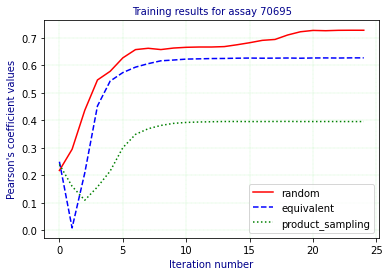

In [17]:
pd.DataFrame(pearson_trn, columns=clf_list_names).to_csv('../data/data_results/{0}_{1}/pearsons_training_set_{2}.csv'.format(model,fingerprint,num_iterations),index=False)
pd.DataFrame(pearson_tst, columns=clf_list_names).to_csv('../data/data_results/{0}_{1}/pearsons_test_set_{2}.csv'.format(model,fingerprint,num_iterations),index=False)

pearson_values_graph = pd.DataFrame(pearson_values_graph, columns=params_config["acquisition"])
pearson_values_graph.to_csv('../data/data_results/{0}_{1}/squared_pearson_{2}.csv'.format(model,fingerprint,flag_first_assay),index=False)

colours = ['-r','--b',':g','^y','-.k','.c','om','xk']
colour_count = 0
font_custom = {
    "family" : "sans-serif",
    "color" : "darkblue",
    "size" : "10"
    }

plt.title("Training results for assay {}".format(flag_first_assay), fontdict=font_custom, loc='center')
plt.xlabel("Iteration number", fontdict=font_custom)
plt.ylabel("Pearson's coefficient values", fontdict=font_custom)


for (column_name,column_contents) in pearson_values_graph.iteritems():
    plt.plot([x for x in range(len(column_contents))],column_contents, colours[colour_count], label='{}'.format(column_name))
    colour_count +=1
plt.grid(color = 'lightgreen', linestyle = '--', linewidth =0.25)
plt.legend()
plt.savefig('../data/data_results/{0}_{1}/plots/training_cycles_{2}.jpg'.format(model,fingerprint,flag_first_assay),
                format='jpg',
               )
plt.show()